In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='04:00:00')
w = cluster.scale(6*10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.36.189:39926 Dashboard: /user/yux/proxy/8787/status,Cluster Workers: 60 Cores: 60 Memory: 1.00 TB


#### This script is to compute spectral density of (part 1) ageo., (part 2) geo. and (part 3) total KE. with comparison in part 4
#### The spectral diagnostics are computed with detrending but no windowing applied

___________
# Part 1 - ageo. uv

## 1. rotary spectra (for ageostrophic uv)

In [5]:
# parameters for rechunking: time and space
Nt, Ni, Nj = 0, 188, 96
dij=4

In [6]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>


In [7]:
# coriolis term
lat = grd_rspec['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [8]:
def _get_E_detrend(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'boxcar', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E_detrend(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 60*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E_detrend(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E_detrend, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')    

In [9]:
# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = work_data_dir+'xy/Ageo_uv_detrend/E_ageo_uv_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        fs = f_ij.isel(face=face, i=slice(0,None,dij), j=slice(0,None,dij))
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))

        # !!! check signs (checked on 08/30), will need to be normalized by Coriolis frequency !!!
        # compute ageostrophic velocities
        ds['u_ageo'] =  (ds['v_gradp'] -  ds['v_coriolis_linear'])/fs
        ds['v_ageo'] =  (-ds['u_gradp'] +  ds['u_coriolis_linear'])/fs
        
        # generate a complex vector variable
        ds['uv_ageo'] = ds['u_ageo'].fillna(0.) + 1j * ds['v_ageo'].fillna(0.)    

        # should show the size of the dataset to know if we can load it in memory
        #print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E_detrend(ds['uv_ageo'].isel(i=2,j=2))
        #
        E = get_E_detrend(ds['uv_ageo'], f=f)        

        # store
        E = E.to_dataset()
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)        
        E = E.chunk({'i': 24*8, 'j':47*4})
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 1s, sys: 2.3 s, total: 1min 4s
Wall time: 2min 32s
--- face 0 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 24s, sys: 2.49 s, total: 1min 27s
Wall time: 4min 15s
--- face 1 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 7s, sys: 2.23 s, total: 1min 10s
Wall time: 2min 48s
--- face 2 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 53.8 s, sys: 1.81 s, total: 55.6 s
Wall time: 2min 6s
--- face 3 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 26s, sys: 2.44 s, total: 1min 28s
Wall time: 4min 47s
--- face 4 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 50.3 s, sys: 1.9 s, total: 52.2 s
Wall time: 1min 57s
--- face 5 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 30s, sys: 2.71 s, total: 1min 33s
Wall time: 3min 14s
--- face 6 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 29s, sys: 2.71 s, total: 1min 32s
Wall time: 4min 20s
--- face 7 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 31s, sys: 2.6 s, total: 1min 34s
Wall time: 5min 5s
--- face 8 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 9s, sys: 2.18 s, total: 1min 11s
Wall time: 3min 12s
--- face 9 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 12s, sys: 2.1 s, total: 1min 14s
Wall time: 2min 59s
--- face 10 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 22s, sys: 2.5 s, total: 1min 24s
Wall time: 4min 4s
--- face 11 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 11s, sys: 2.16 s, total: 1min 14s
Wall time: 2min 50s
--- face 12 done


## 2. band-integral results (KE)
### band integral of spectra

In [10]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for face in face_all:
    
    ds = xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/E_ageo_uv_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)     
    E = ds.uv_ageo
    #E = E.assign_coords(freq_cps=E.freq_time / 86400.) 
    df=E.freq_time[1]-E.freq_time[0]

    # total KE
    E_all = (E*df).sum(dim='freq_time')
    E_all = E_all.chunk({'i': 1080, 'j': 1080}) 
    E_all = np.real(E_all).rename('E_all')

    # high-frequency KE (<0.5 day)
    E_high = (E.where(abs(E.freq_time)>0.5, other=0.)*df).sum(dim='freq_time')
    E_high = E_high.chunk({'i': 1080, 'j': 1080}) 
    E_high = np.real(E_high).rename('E_high')

    # semi-diurnal
    E_semi = (E.where((abs(E.freq_time)>1.9) & (abs(E.freq_time)<2.1), other=0.)*df).sum(dim='freq_time')
    E_semi = E_semi.chunk({'i': 1080, 'j': 1080}) 
    E_semi = np.real(E_semi).rename('E_semi')

    # diurnal
    E_diurnal = (E.where((abs(E.freq_time)>0.9) & (abs(E.freq_time)<1.1), other=0.)*df).sum(dim='freq_time')
    E_diurnal = E_diurnal.chunk({'i': 1080, 'j': 1080}) 
    E_diurnal = np.real(E_diurnal).rename('E_diurnal')
    
    # near-inertial
    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
    f_cpd_llc = f_llc*86400/2./np.pi
    E_f = (E.where((abs(E.freq_time+f_cpd_llc)<0.1), other=0.)*df).sum(dim='freq_time')
    E_f = np.real(E_f).rename('E_f')

    # low-frequency KE (>0.5 day)    
    E_low = E_all - E_high
    E_low = E_low.chunk({'i': 1080, 'j': 1080}) 
    E_low = np.real(E_low).rename('E_low')

    # merge together
    E_band = xr.merge([E_high, E_semi, E_diurnal, E_f, E_all, E_low])
    
    file_E = work_data_dir+'xy/Ageo_uv_detrend/E_band_integral_f%02d.zarr'%face
    E_band.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

face 0 done
face 1 done
face 2 done
face 3 done
face 4 done
face 5 done
face 6 done
face 7 done
face 8 done
face 9 done
face 10 done
face 11 done
face 12 done


In [11]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_all = xr.concat(D, dim='face')
print(ds_all)

<xarray.Dataset>
Dimensions:    (face: 13, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4

## 3. zonal average of rotary spectra

In [12]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

<xarray.DataArray 'AREA' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

In [13]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [14]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/E_ageo_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11

In [15]:
v = 'uv_ageo'
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
F = [11]

In [16]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    #E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False) # filter out shallow depths
    E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False).where(lice>0) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/Ageo_uv_detrend/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 0 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 1 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 2 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 3 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 4 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 5 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 6 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 7 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 8 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 9 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 10 done


<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 12 done


In [17]:
F = [11]

for face in F:
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    lice = ice.isel(face=face)
    E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False).where(lice>0)  # filter out shallow depths
    #E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/Ageo_uv_detrend/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

<ipython-input-13-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-13-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 11 done


In [18]:
v = 'uv_ageo'
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
print(ds_zav)

<xarray.Dataset>
Dimensions:    (freq_time: 1440, latitude: 119)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    S_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>
    W_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>


In [19]:
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


_____________________
# Part 2 geo uv
## 1. rotary spectra

In [48]:
# parameters for rechunking: time and space
Nt, Ni, Nj = 0, 188, 96
dij=4

V = ['u','v']
terms = ['coriolis_linear','gradp']

In [49]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>


In [50]:
# coriolis term
lat = grd_rspec['YC']
omega = 7.3/100000
f_ij = 2*omega*np.sin(np.deg2rad(lat))
f_ij

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<mul, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [ ]:
# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = work_data_dir+'xy/geo_uv_detrend/E_geo_uv_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        fs = f_ij.isel(face=face, i=slice(0,None,dij), j=slice(0,None,dij))
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))

        # !!! check signs (checked on 08/30), will need to be normalized by Coriolis frequency !!!
        # compute ageostrophic velocities
        ds['u_geo'] =  (-ds['v_gradp'])/fs
        ds['v_geo'] =  (ds['u_gradp'])/fs
        
        # generate a complex vector variable
        ds['uv_geo'] = ds['u_geo'].fillna(0.) + 1j * ds['v_geo'].fillna(0.)    

        # should show the size of the dataset to know if we can load it in memory
        print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E_detrend(ds['uv_geo'].isel(i=2,j=2))
        #
        E = get_E_detrend(ds['uv_geo'], f=f)

        # store
        E = E.to_dataset()
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)        
        E = E.chunk({'i': 24*8, 'j':47*4})
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 41.3 s, sys: 1.31 s, total: 42.6 s
Wall time: 1min 46s
--- face 0 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 56 s, sys: 1.73 s, total: 57.7 s
Wall time: 2min 43s
--- face 1 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 47.9 s, sys: 1.71 s, total: 49.6 s
Wall time: 2min 36s
--- face 2 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 38.5 s, sys: 1.44 s, total: 40 s
Wall time: 1min 59s
--- face 3 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min 2s, sys: 2.1 s, total: 1min 5s
Wall time: 3min 27s
--- face 4 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 37.2 s, sys: 1.2 s, total: 38.4 s
Wall time: 2min 5s
--- face 5 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 59.3 s, sys: 1.69 s, total: 1min 1s
Wall time: 1min 26s
--- face 6 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 56.2 s, sys: 1.75 s, total: 57.9 s
Wall time: 2min 53s
--- face 7 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 58.7 s, sys: 1.94 s, total: 1min
Wall time: 3min 2s
--- face 8 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 43.2 s, sys: 1.57 s, total: 44.8 s
Wall time: 2min 11s
--- face 9 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 47.5 s, sys: 1.42 s, total: 48.9 s
Wall time: 1min 52s
--- face 10 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 54 s, sys: 1.74 s, total: 55.7 s
Wall time: 3min 1s
--- face 11 done
dataset size: 322.5 GB


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time


## 2. band-integral results (KE)
### band integral of spectra

In [24]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


for face in face_all:
    
    ds = xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/E_geo_uv_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)     
    E = ds.uv_geo
    #E = E.assign_coords(freq_cps=E.freq_time / 86400.) 
    df=E.freq_time[1]-E.freq_time[0]

    # total KE
    E_all = (E*df).sum(dim='freq_time')
    E_all = E_all.chunk({'i': 1080, 'j': 1080}) 
    E_all = np.real(E_all).rename('E_all')
    # high-frequency KE (<0.5 day)
    E_high = (E.where((abs(E.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
    E_high = E_high.chunk({'i': 1080, 'j': 1080}) 
    E_high = np.real(E_high).rename('E_high')
    # semi-diurnal
    E_semi = (E.where((abs(E.freq_time)>1.9) & (abs(E.freq_time)<2.1), other=0.)*df).sum(dim='freq_time')
    E_semi = E_semi.chunk({'i': 1080, 'j': 1080}) 
    E_semi = np.real(E_semi).rename('E_semi')
    # diurnal
    E_diurnal = (E.where((abs(E.freq_time)>0.9) & (abs(E.freq_time)<1.1), other=0.)*df).sum(dim='freq_time')
    E_diurnal = E_diurnal.chunk({'i': 1080, 'j': 1080}) 
    E_diurnal = np.real(E_diurnal).rename('E_diurnal')
    # near-inertial
    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
    f_cpd_llc = f_llc*86400/2./np.pi
    E_f = (E.where((abs(E.freq_time+f_cpd_llc)<0.1), other=0.)*df).sum(dim='freq_time')
    E_f = np.real(E_f).rename('E_f')
    # low-frequency KE (>0.5 day)    
    E_low = E_all - E_high
    E_low = E_low.chunk({'i': 1080, 'j': 1080}) 
    E_low = np.real(E_low).rename('E_low')
    
    # merge together
    E_band = xr.merge([E_high, E_semi, E_diurnal, E_f, E_all, E_low])
    
    file_E = work_data_dir+'xy/geo_uv_detrend/E_band_integral_f%02d.zarr'%face
    E_band.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

face 0 done
face 1 done
face 2 done
face 3 done
face 4 done
face 5 done
face 6 done
face 7 done
face 8 done
face 9 done
face 10 done
face 11 done
face 12 done


In [25]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_all = xr.concat(D, dim='face')
print(ds_all)

<xarray.Dataset>
Dimensions:    (face: 13, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4

## 3. Zonal average 

In [26]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [27]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

<xarray.DataArray 'AREA' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

In [28]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/E_geo_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11

In [29]:
v = 'uv_geo'

In [30]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

for face in F:
    
    lice = ice.isel(face=face)
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    E = lds.uv_geo.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False).where(lice>0) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/geo_uv_detrend/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 0 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 1 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 2 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 3 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 4 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 5 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 6 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 7 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 8 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 9 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 10 done


<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 12 done


In [31]:
F = [11]

for face in F:
    
    lice = ice.isel(face=face)
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    E = lds.uv_geo.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/geo_uv_detrend/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

<ipython-input-26-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-26-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 11 done


In [33]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
print(ds_zav)

<xarray.Dataset>
Dimensions:    (freq_time: 1440, latitude: 119)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    S_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>
    W_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>


In [34]:
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


_____

# Part 3 - total uv

## 1. rotary spectra (for total uv)

In [20]:
# parameters for rechunking: time and space
Nt, Ni, Nj = 0, 188, 96
dij=4

In [21]:
#grd = load_grd(ftype='nc').reset_coords()
grd = load_grd().reset_coords()
mask = ((grd.hFacW.rename({'i_g': 'i'}) == 1) &
        (grd.hFacS.rename({'j_g': 'j'}) == 1) 
       ).rename('mask').reset_coords(drop=True)
grd_rspec = xr.merge([mask, grd.XC, grd.YC, grd.Depth])
print(grd_rspec)

# !! chunking is coarse for the netcdf grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mask     (face, j, i) bool dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>


In [22]:
# spatial strides for decimation
dij=4
overwrite=True
    
for face in range(13):
#for face in [1]:

    Efile = work_data_dir+'xy/total_uv_detrend/E_uv_f%02d.zarr'%(face)

    if not os.path.isdir(Efile) or overwrite:

        # load data
        dsu = ( xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('u',face))
                .isel(i_g=slice(0,None,dij), j=slice(0,None,dij)) )
        dsv = (xr.open_zarr(work_data_dir+'rechunked/%s_mbal_xy_f%02d.zarr'%('v',face))
               .isel(i=slice(0,None,dij), j_g=slice(0,None,dij)) )
        fs = f_ij.isel(face=face, i=slice(0,None,dij), j=slice(0,None,dij))
        
        ds = xr.merge([dsu.rename({'i_g': 'i'}), dsv.rename({'j_g': 'j'})], 
                      compat='equals').assign_coords(**grd_rspec.sel(face=face))

        # !!! check signs (checked on 08/30), will need to be normalized by Coriolis frequency !!!
        # compute ageostrophic velocities
        ds['u'] =  -ds['v_coriolis_linear']/fs
        ds['v'] =  ds['u_coriolis_linear']/fs
        
        # generate a complex vector variable
        ds['uv'] = ds['u'].fillna(0.) + 1j * ds['v'].fillna(0.)    

        # should show the size of the dataset to know if we can load it in memory
        #print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

        # spectral computation
        # need to run once to get frequency line
        f, E = get_E_detrend(ds['uv'].isel(i=2,j=2))
        #
        E = get_E_detrend(ds['uv'], f=f)

        # store
        E = E.to_dataset()
        for c in E.coords:
            try:
                del E[c].encoding['chunks']
            except:
                print(c)        
        E = E.chunk({'i': 24*8, 'j':47*4})
        %time E.to_zarr(Efile, mode='w')

        print('--- face %d done'%face)

    else:
        print('--- face %d allready computed'%face)

<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 40 s, sys: 1.45 s, total: 41.5 s
Wall time: 1min 56s
--- face 0 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 55.2 s, sys: 1.84 s, total: 57 s
Wall time: 2min 57s
--- face 1 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 48 s, sys: 1.59 s, total: 49.6 s
Wall time: 2min 21s
--- face 2 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 35.1 s, sys: 1.15 s, total: 36.3 s
Wall time: 1min 35s
--- face 3 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 1min, sys: 1.9 s, total: 1min 2s
Wall time: 2min 50s
--- face 4 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 36 s, sys: 1.22 s, total: 37.3 s
Wall time: 1min 26s
--- face 5 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 52.8 s, sys: 1.69 s, total: 54.4 s
Wall time: 2min 30s
--- face 6 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 58.6 s, sys: 1.79 s, total: 1min
Wall time: 2min 38s
--- face 7 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 59.9 s, sys: 2 s, total: 1min 1s
Wall time: 3min 6s
--- face 8 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 51.2 s, sys: 1.75 s, total: 52.9 s
Wall time: 1min 55s
--- face 9 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 41.2 s, sys: 1.36 s, total: 42.5 s
Wall time: 2min 7s
--- face 10 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 52.3 s, sys: 1.69 s, total: 54 s
Wall time: 2min 44s
--- face 11 done


<ipython-input-8-3d74f19f8978>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E_detrend, v,
/home/uz/yux/.conda/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


mask
freq_time
CPU times: user 42.5 s, sys: 1.61 s, total: 44.1 s
Wall time: 2min 6s
--- face 12 done


## 2. band-integral results (KE)
### band integral of spectra

In [35]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for face in face_all:
    
    ds = xr.open_zarr(work_data_dir+'xy/total_uv_detrend/E_uv_f%02d.zarr'%(face))
    chunks={'i': 188, 'j':192, 'freq_time':1440}
    ds = ds.chunk(chunks)     
    E = ds.uv
    #E = E.assign_coords(freq_cps=E.freq_time / 86400.) 
    df=E.freq_time[1]-E.freq_time[0]

    # total KE
    E_all = (E*df).sum(dim='freq_time')
    E_all = E_all.chunk({'i': 1080, 'j': 1080}) 
    E_all = np.real(E_all).rename('E_all')
    
    # high-frequency KE (<0.5 day)
    E_high = (E.where((abs(E.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
    E_high = E_high.chunk({'i': 1080, 'j': 1080}) 
    E_high = np.real(E_high).rename('E_high')
    
    # semi-diurnal
    E_semi = (E.where((abs(E.freq_time)>1.9) & (abs(E.freq_time)<2.1), other=0.)*df).sum(dim='freq_time')
    E_semi = E_semi.chunk({'i': 1080, 'j': 1080}) 
    E_semi = np.real(E_semi).rename('E_semi')
    
    # diurnal
    E_diurnal = (E.where((abs(E.freq_time)>0.9) & (abs(E.freq_time)<1.1), other=0.)*df).sum(dim='freq_time')
    E_diurnal = E_diurnal.chunk({'i': 1080, 'j': 1080}) 
    E_diurnal = np.real(E_diurnal).rename('E_diurnal')
    
    # near-inertial
    f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
    f_cpd_llc = f_llc*86400/2./np.pi
    E_f = (E.where((abs(E.freq_time+f_cpd_llc)<0.1), other=0.)*df).sum(dim='freq_time')
    E_f = np.real(E_f).rename('E_f')
    
    # low-frequency KE (>0.5 day)    
    E_low = E_all - E_high
    E_low = E_low.chunk({'i': 1080, 'j': 1080}) 
    E_low = np.real(E_low).rename('E_low')
    
    # merge together
    E_band = xr.merge([E_high, E_semi, E_diurnal, E_f, E_all, E_low])
    
    file_E = work_data_dir+'xy/total_uv_detrend/E_band_integral_f%02d.zarr'%face
    E_band.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

face 0 done
face 1 done
face 2 done
face 3 done
face 4 done
face 5 done
face 6 done
face 7 done
face 8 done
face 9 done
face 10 done
face 11 done
face 12 done


In [36]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
D = [xr.open_zarr(work_data_dir+'xy/total_uv_detrend/E_band_integral_f%02d.zarr'%(face)) for face in face_all] 
ds_all = xr.concat(D, dim='face')
print(ds_all)

<xarray.Dataset>
Dimensions:    (face: 13, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.array<chunksize=(1, 192, 188), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4

## 3. Zonal average 

In [37]:
latb = np.arange(-60.,60.,1.)
latc = (latb[:-1]+latb[1:])*.5

def _zhist(x, lat, weights=True):
    # an alternative would be to create xarray dataarrays and use groupby_bins
    # https://github.com/pydata/xarray/issues/1765
    if weights:
        w = x
    else:
        w = np.ones_like(x)
    h, edges = np.histogram(lat, bins=latb, weights=w, density=False)
    return h[None,:]

def zaverage(v):
    dims = ['i','j']
    v = v.fillna(0.)
    lat = v.YC+0.*v
    #
    S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    S = S.assign_coords(latitude=latc).rename('S_SSUV')
    #
    W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},
                    output_core_dims=[['latitude']], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={'latitude': len(latc)})
    W = W.assign_coords(latitude=latc).rename('W_SSUV')    
    return xr.merge([S, W], compat='identical')

In [38]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv_detrend/E_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')
print(ds)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dxG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyC        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    dyG        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    f_i        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
    f_j        (face, j, i) float32 dask.array<chunksize=(1, 188, 192), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11

In [39]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij)) 
ice

<xarray.DataArray 'AREA' (face: 13, j: 1080, i: 1080)>
dask.array<getitem, shape=(13, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

In [40]:
v = 'uv'
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]

In [41]:
for face in F:
    
    lice = ice.isel(face=face)
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    #E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False) # filter out shallow depths
    E = lds.uv.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False).where(lice>0) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/total_uv_detrend/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 0 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 1 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 2 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 3 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 4 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 5 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 6 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 7 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 8 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 9 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 10 done


<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 12 done


In [42]:
F = [11]

for face in F:
    
    lice = ice.isel(face=face)
    lds = ds.isel(face=face).chunk({'i': None, 'j': None,'freq_time':1})
    E = lds.uv.isel(i=slice(1,-1),j=slice(1,-1)).where((lds.Depth>2000.) & (lds.j!=40), drop=False).where(lice>0) # filter out shallow depths
    #E = lds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where(lds.Depth>2000., drop=False) # filter out shallow depths
    Eds = zaverage(E).chunk({'freq_time':None})
    Efile = work_data_dir+'xy/total_uv_detrend/%s_f%02d_zav.zarr'%(v, face)
    Eds.to_zarr(Efile, mode='w')
    print('--- face %d done'%face)

<ipython-input-37-e77591e81e76>:19: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  S = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': True},
<ipython-input-37-e77591e81e76>:26: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  W = xr.apply_ufunc(_zhist, v, lat, kwargs={'weights': False},


--- face 11 done


In [45]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
print(ds_zav)

<xarray.Dataset>
Dimensions:    (freq_time: 1440, latitude: 119)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    S_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>
    W_SSUV     (freq_time, latitude) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>


In [46]:
E_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


_________

# Part 4 comparison

## 4.1. global-mean rotary spectra

### $E_{ageo}(\omega)$, $E_{geo}(\omega)$ and $E_{total}(\omega)$

In [47]:
#F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
F = [1,2,4,5,7,8,10]

In [48]:
ds_ice = xr.open_zarr(work_data_dir+'xy/sea_ice_mask.zarr')
dij=4 
ice = ds_ice.AREA.isel(i=slice(0,None,dij), j=slice(0,None,dij), face=F ) 
ice

<xarray.DataArray 'AREA' (face: 7, j: 1080, i: 1080)>
dask.array<getitem, shape=(7, 1080, 1080), dtype=float64, chunksize=(1, 1080, 1080), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 1 2 4 5 7 8 10
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316

In [49]:
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/E_ageo_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')

E_ageo_uv_mean = (ds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC>10) & (ds.Depth>2000))).mean(dim=('i','j','face'))

E_ageo_uv_mean_2 = (ds.uv_ageo.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000))).mean(dim=('i','j','face'))
E_ageo_uv_mean_2 = E_ageo_uv_mean_2.assign_coords(freq_time=E_ageo_uv_mean_2.freq_time * -1.) 

In [50]:
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/E_geo_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')

E_geo_uv_mean = (ds.uv_geo.isel(i=slice(1,-1),j=slice(1,-1)).where( (ds.YC>10) & (ds.Depth>2000))).mean(dim=('i','j','face'))

E_geo_uv_mean_2 = (ds.uv_geo.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000))).mean(dim=('i','j','face'))
E_geo_uv_mean_2 = E_geo_uv_mean_2.assign_coords(freq_time=E_geo_uv_mean_2.freq_time * -1.) 

In [51]:
ds = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv_detrend/E_uv_f%02d.zarr'%(face))
              for face in F], dim='face', compat='identical')

E_total_uv_mean = (ds.uv.isel(i=slice(1,-1),j=slice(1,-1)).where( (ds.YC>10) & (ds.Depth>2000))).mean(dim=('i','j','face'))

E_total_uv_mean_2 = (ds.uv.isel(i=slice(1,-1),j=slice(1,-1)).where((ds.YC<-10) & (ds.Depth>2000))).mean(dim=('i','j','face'))
E_total_uv_mean_2 = E_total_uv_mean_2.assign_coords(freq_time=E_total_uv_mean_2.freq_time * -1.) 

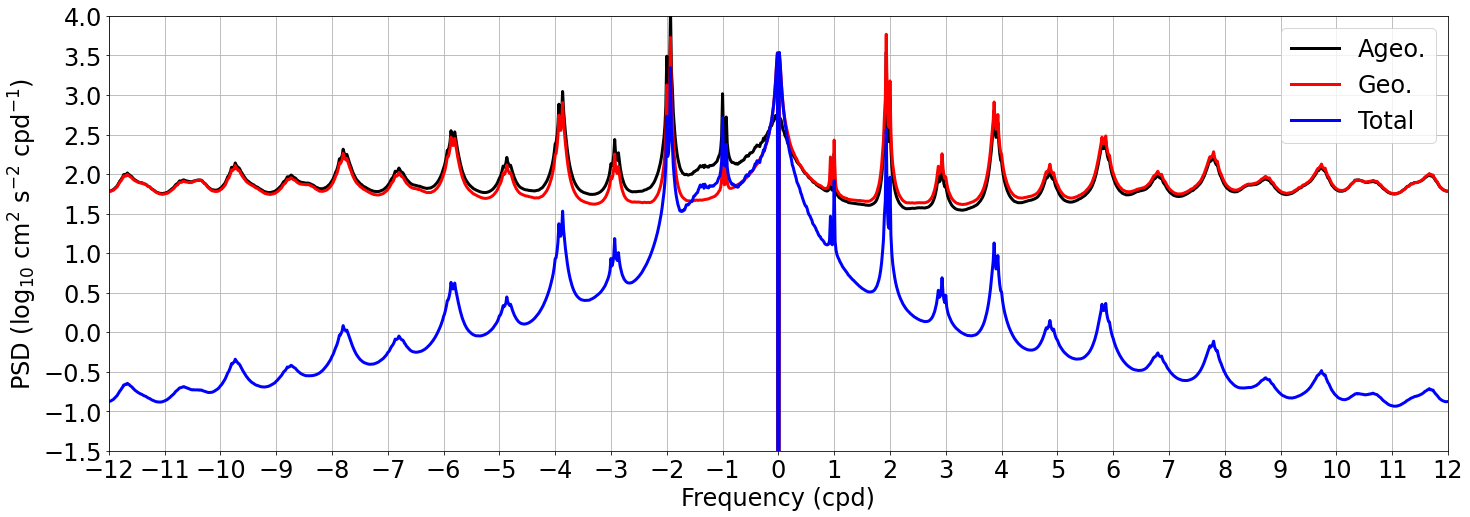

In [52]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Ageo.', 'Geo.', 'Total']

(np.log10((E_ageo_uv_mean_2+E_ageo_uv_mean)*86400/2/6)).plot(ax=ax,color='black', label=labels[0],linewidth=3)
(np.log10((E_geo_uv_mean_2+E_geo_uv_mean)*86400/2/6)).plot(ax=ax,color='red', label=labels[1],linewidth=3)
(np.log10((E_total_uv_mean_2+E_total_uv_mean)*86400/2/6)).plot(ax=ax,label=labels[2],color='blue',linewidth=3)
ax.grid()
ax.legend()
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5, 4.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

#plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_globalmean_spectra.png')

__________
## 4. 2. spectral comparison 
### $E_{ageo}(\omega, lat)$, $E_{geo}(\omega, lat)$ and $E_{total}(\omega, lat)$

In [53]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
v = 'uv_ageo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_ageo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [54]:
v = 'uv'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_total_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_total_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [55]:
v = 'uv_geo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_geo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


Text(0.5, 0, 'Frequency (cpd)')

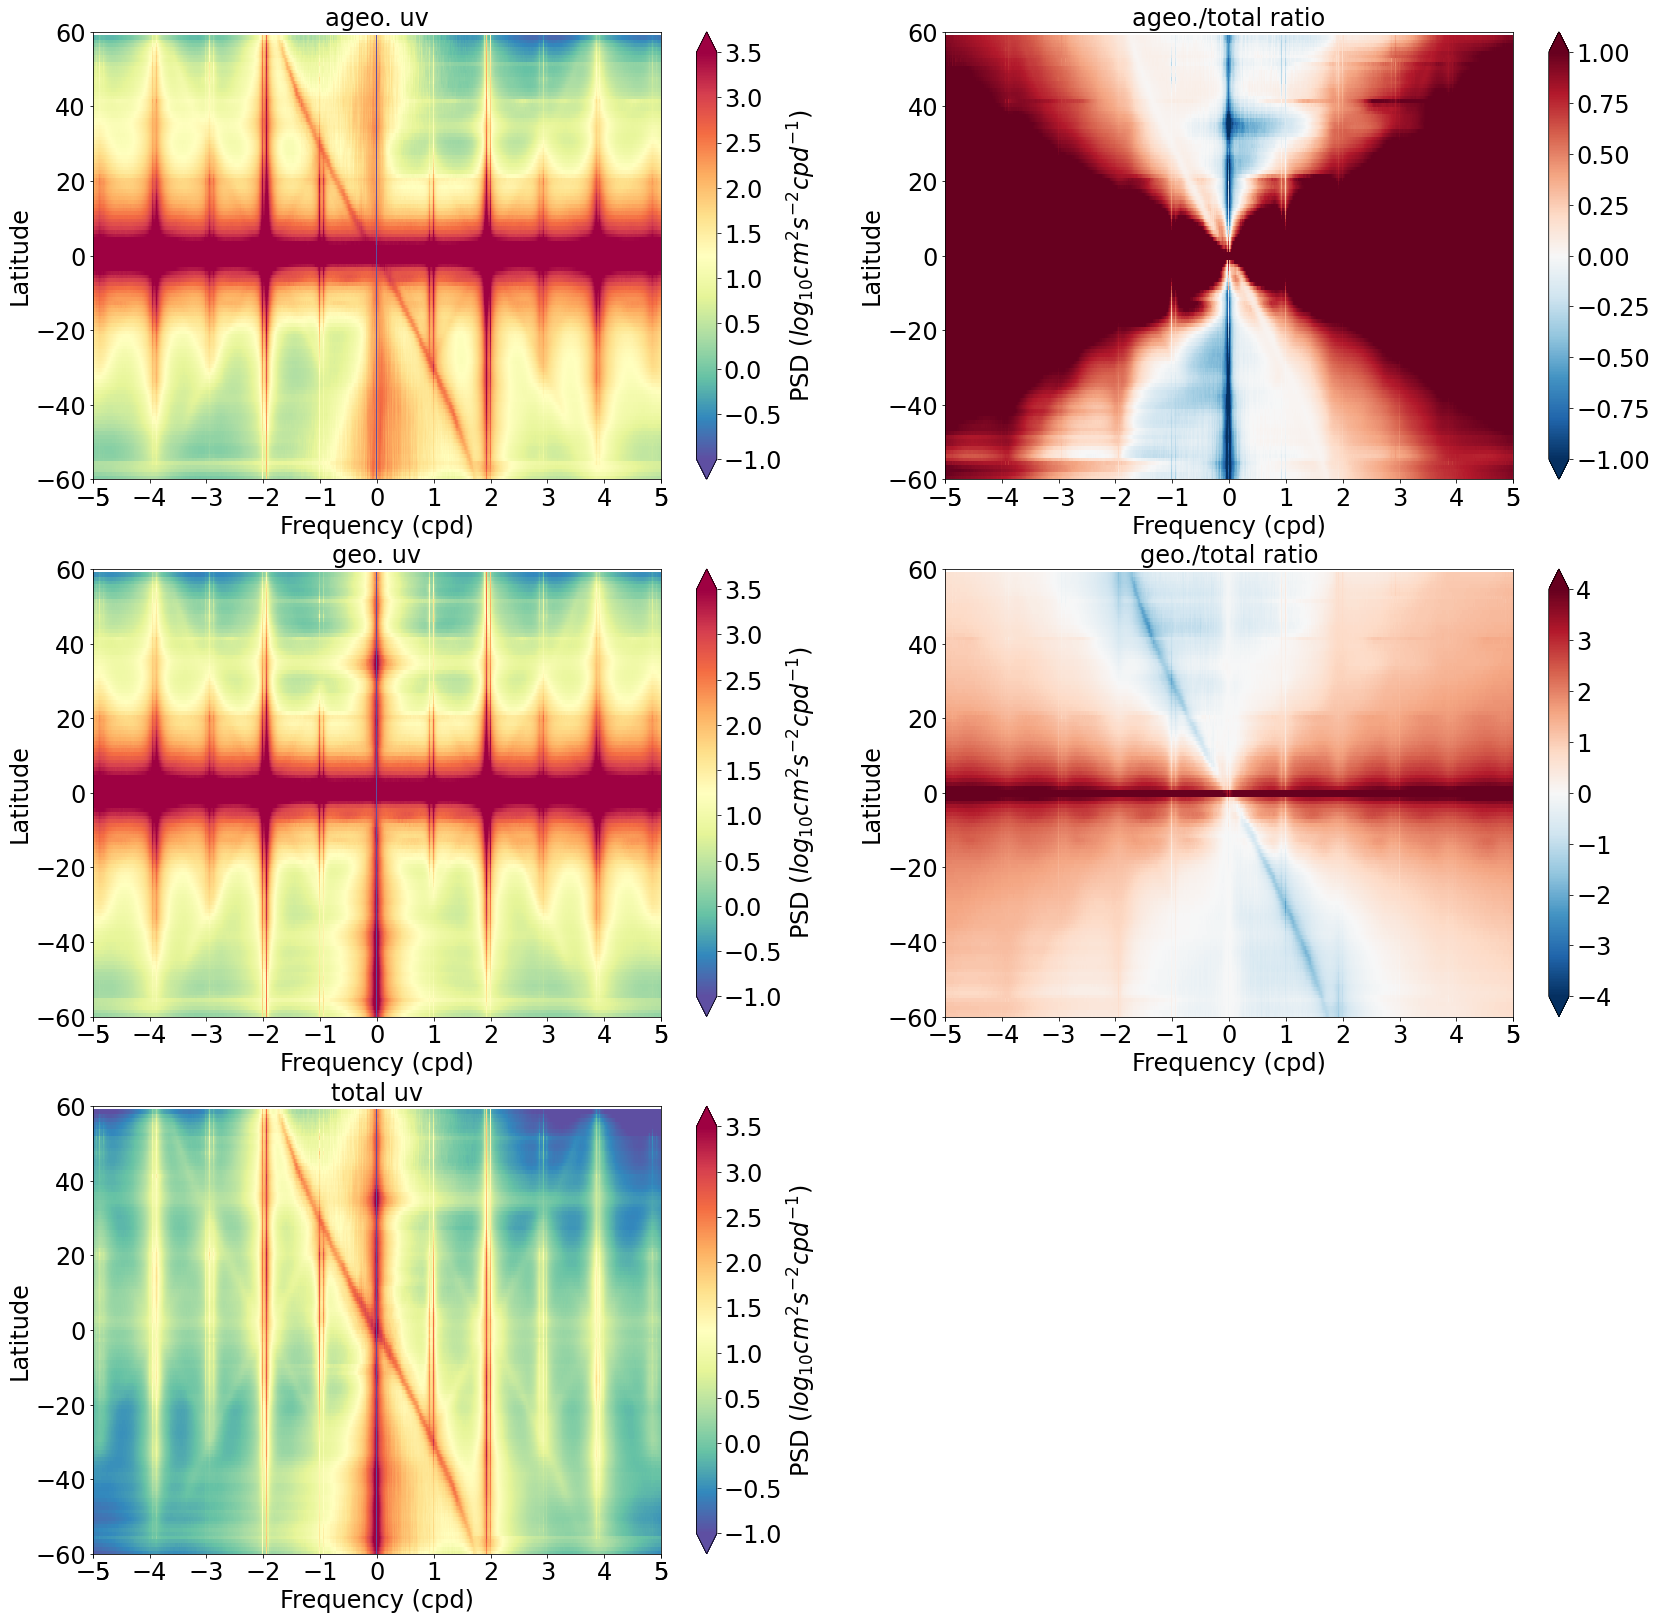

In [56]:
font_size = 24

fig, ax = plt.subplots(figsize=(28,28))

ax = plt.subplot(321)
cax=np.log10(E_ageo_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)

ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('ageo. uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(323)
cax=np.log10(E_geo_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('geo. uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(325)
cax=np.log10(E_total_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('total uv',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(322)
cax=np.log10(E_ageo_zav/E_total_zav).plot(vmin=-1, vmax=1, x='freq_time', y='latitude', cmap='RdBu_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('ageo./total ratio',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax = plt.subplot(324)
cax=np.log10(E_geo_zav/E_total_zav).plot(vmin=-4, vmax=4, x='freq_time', y='latitude', cmap='RdBu_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-5.,-4., -3., -2., -1., 1., 2., 3., 4.,5.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('geo./total ratio',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

#plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_zonalmean_spectra.png')

## 4.3 Spectral integrals (only for ageostrophic uv)


## low-freq $\int_{0}^{0.5 cpd} E_{ageo}(\omega, lat) d\omega$ vs.  high-freq $\int_{0.5 cpd}^{12 cpd} E_{ageo}(\omega, lat) d\omega$

In [57]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

v = 'uv'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_total_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_total_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [58]:
v = 'uv_geo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_geo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [59]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
v = 'uv_ageo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv_detrend/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_ageo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [60]:
df=E_ageo_zav.freq_time[1]-E_ageo_zav.freq_time[0]
df

<xarray.DataArray 'freq_time' ()>
array(0.01666667)

In [61]:
E_total_all = (E_total_zav*df).sum(dim='freq_time')
E_total_all = E_total_all.chunk({'latitude': 1}) 
E_total_all = np.real(E_total_all).rename('E_total_all')

E_total_high = (E_total_zav.where((abs(E_total_zav.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
E_total_high = E_total_high.chunk({'latitude': 1}) 
E_total_high = np.real(E_total_high).rename('E_total_high')

E_total_low = E_total_all - E_total_high
E_total_low = E_total_low.chunk({'latitude': 1}) 
E_total_low = np.real(E_total_low).rename('E_total_low')

In [62]:
E_ageo_all = (E_ageo_zav*df).sum(dim='freq_time')
E_ageo_all = E_ageo_all.chunk({'latitude': 1}) 
E_ageo_all = np.real(E_ageo_all).rename('E_ageo_all')

E_ageo_high = (E_ageo_zav.where((abs(E_ageo_zav.freq_time)>0.5), other=0.)*df).sum(dim='freq_time')
E_ageo_high = E_ageo_high.chunk({'latitude': 1}) 
E_ageo_high = np.real(E_ageo_high).rename('E_ageo_high')

E_ageo_low = E_ageo_all - E_ageo_high
E_ageo_low = E_ageo_low.chunk({'latitude': 1}) 
E_ageo_low = np.real(E_ageo_low).rename('E_ageo_low')

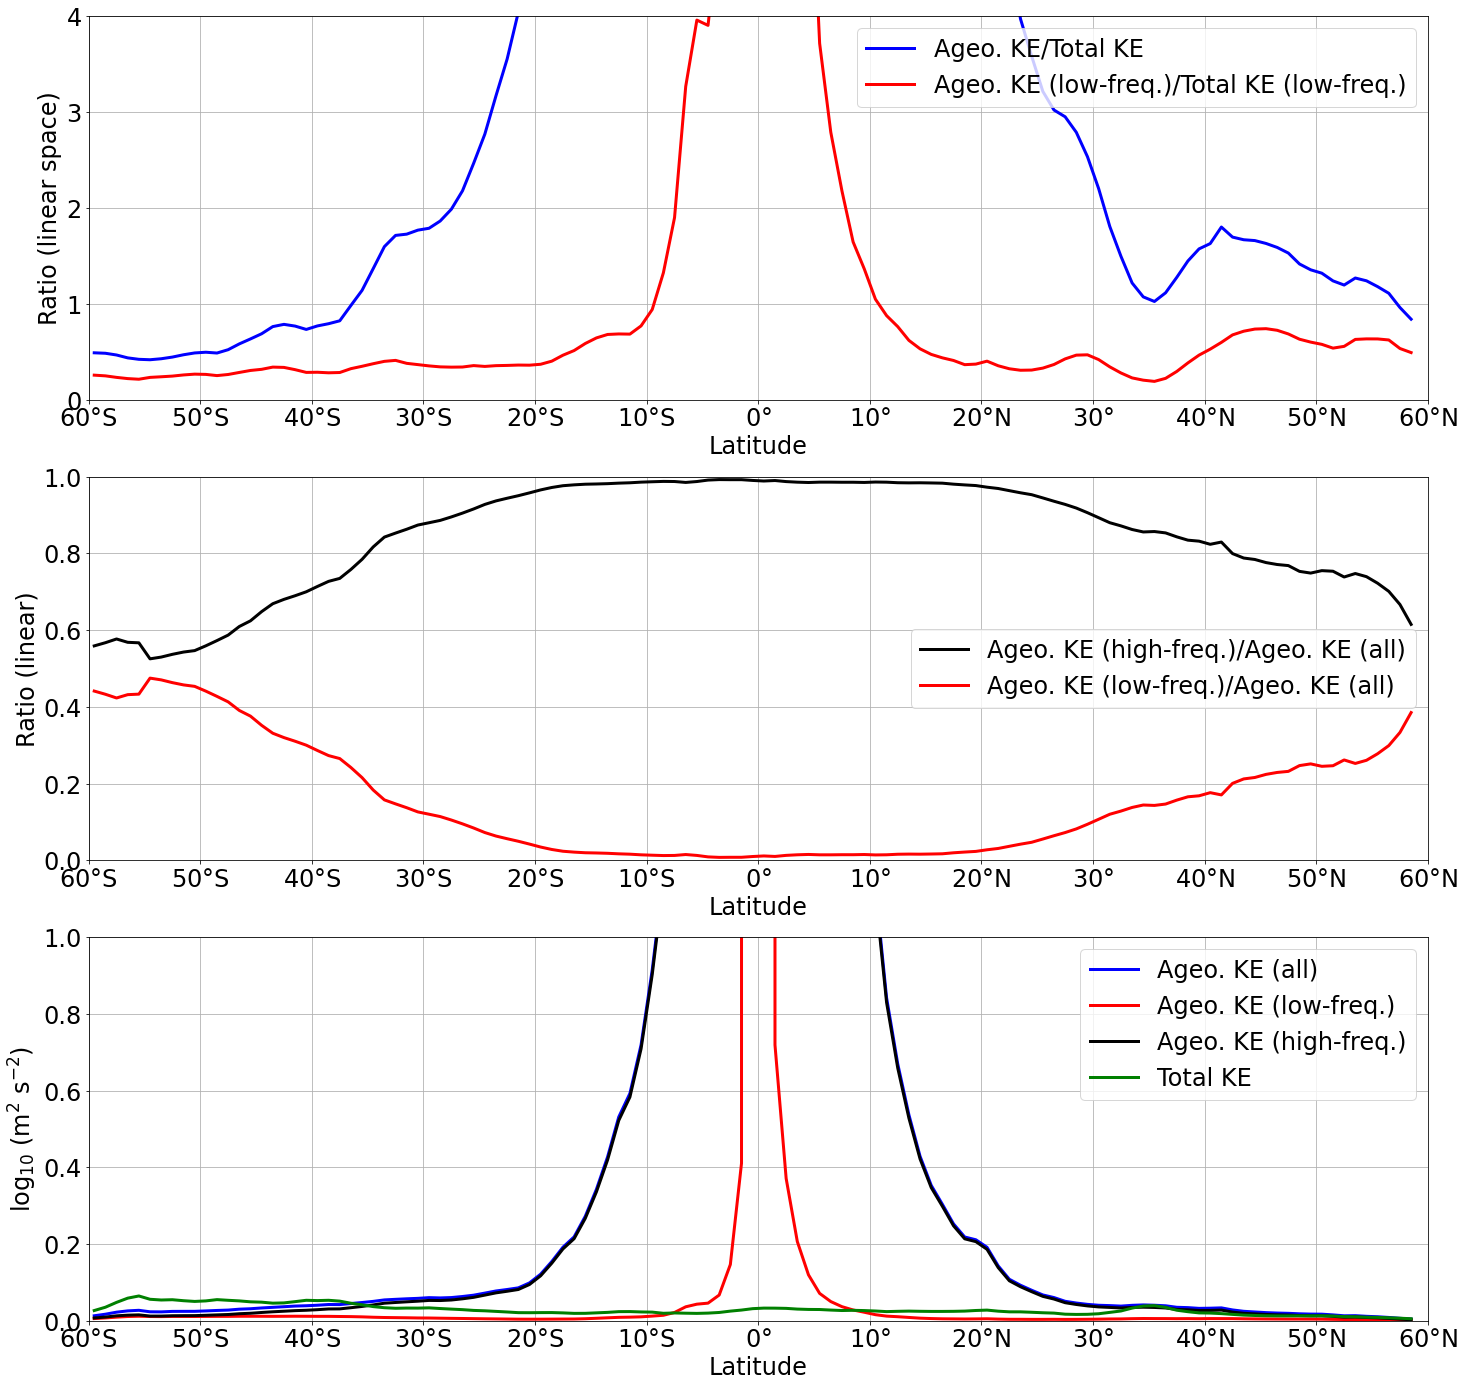

In [63]:
font_size = 24

fig, ax = plt.subplots(figsize=(24,24))

ax = plt.subplot(311)
labels = ['Ageo. KE/Total KE', 'Ageo. KE (low-freq.)/Total KE (low-freq.)']
(E_ageo_all/E_total_all).plot(ax=ax,x='latitude',color='blue',label=labels[0],  linewidth=3)
(E_ageo_low/E_total_low).plot(ax=ax,x='latitude',color='red',label=labels[1],  linewidth=3)
ax.grid()
ax.legend()
ax.set_xlim(-60., 60.)
ax.set_ylim(0, 4.)
ax.set_xticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticks([0., 1., 2., 3., 4.])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$','$20\degree$N','$30\degree$','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.legend(prop={'size': 24})
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Ratio (linear space)',fontsize=24)
ax.tick_params(labelsize=24)

ax = plt.subplot(312)
labels = ['Ageo. KE (high-freq.)/Ageo. KE (all)', 'Ageo. KE (low-freq.)/Ageo. KE (all)']
(E_ageo_high/E_ageo_all).plot(ax=ax,x='latitude',color='black',label=labels[0],  linewidth=3)
(E_ageo_low/E_ageo_all).plot(ax=ax,x='latitude',color='red',label=labels[1],  linewidth=3)
ax.grid()
ax.legend()
ax.set_ylim(0., 1.)
ax.set_xlim(-60., 60.)
#ax.set_yticks([-3, -2, -1, 0., 1., 2., 3., 4., 5.])
ax.set_xticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$','$20\degree$N','$30\degree$','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.legend(prop={'size': 24})
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Ratio (linear)',fontsize=24)
ax.tick_params(labelsize=24)

ax = plt.subplot(313)
labels = ['Ageo. KE (all)', 'Ageo. KE (low-freq.)', 'Ageo. KE (high-freq.)', 'Total KE']
(E_ageo_all).plot(ax=ax,x='latitude',color='blue',label=labels[0],  linewidth=3)
(E_ageo_low).plot(ax=ax,x='latitude',color='red',label=labels[1],  linewidth=3)
(E_ageo_high).plot(ax=ax,x='latitude',color='black',label=labels[2], linewidth=3)
(E_total_all).plot(ax=ax,x='latitude',color='green',label=labels[3],  linewidth=3)
ax.grid()
ax.legend()
ax.set_ylim(0., 1.)
#ax.set_yticks([-3, -2, -1, 0., 1.])
ax.set_xlim(-60., 60.)
ax.set_xticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_xticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$','$20\degree$N','$30\degree$','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.legend(prop={'size': 24})
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('log$_{10}$ (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

#plt.savefig('/home/uz/yux/mit_equinox/hal/Geostrophy_assessment/Figures/Figure_ratio_together.png')

In [66]:
cluster.close()